In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.integrate import dblquad


In [5]:
# Import modules
import os
import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Create ./stan folder if does not exists
if not os.path.exists("./stan/sex"):
    os.mkdir("./stan/sex")

In [6]:
from mpmath import mp
mp.dps = 50

In [7]:
def prior_kernel(s,t):
    return np.exp(-((t-s)/5)**2)+0.0001*(s==t)
sigma = 1
T = np.linspace(1, 288, 288)
K = np.fromfunction(np.vectorize(lambda s, t: prior_kernel(T[s], T[t])), (T.shape[0], T.shape[0]), dtype=int)


In [8]:
df=pd.read_csv("average_curves.csv",index_col="idx")
df

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
idx,,,,,,,,,,,,,,,,,,,,,
pat_number,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,150.000000,151.000000,152.000000,153.000000,154.000000,155.000000,156.000000,157.000000,158.000000,159.000000
severity,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
constancy,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
age,58.000000,59.000000,62.000000,65.000000,65.000000,70.000000,66.000000,74.000000,58.000000,74.000000,...,68.000000,49.000000,51.000000,66.000000,45.000000,74.000000,67.000000,59.000000,34.000000,72.000000
gender,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,-0.981659,-1.076615,-1.332550,-1.058805,-0.923807,-1.109480,-1.743754,-1.184359,-1.359995,-1.107242,...,-1.485589,-1.074087,-1.003103,-0.996204,-1.740179,-1.447827,-1.043098,-1.684661,-1.077221,-1.393487
284,-0.993531,-1.078280,-1.332549,-1.044116,-0.923762,-1.109441,-1.743714,-1.217882,-1.360021,-1.116414,...,-1.486356,-1.074077,-1.002612,-0.994606,-1.740226,-1.445859,-1.042748,-1.684662,-1.077203,-1.393533
285,-0.997926,-1.079618,-1.332558,-1.019142,-0.923818,-1.109399,-1.743523,-1.224489,-1.360155,-1.127783,...,-1.487368,-1.074091,-1.003404,-0.994287,-1.740254,-1.440550,-1.042608,-1.684662,-1.077191,-1.393537


In [9]:
sex=df.iloc[4,:]-1 # male=0 


In [10]:
x = df.iloc[7:,:].T.to_numpy()
y = df.iloc[1, :].T.to_numpy()

y23 = np.copy(y)
y23[y == 1] = 0
y23[y == 2] = 1
y23[y == 3] = 1
np.unique(y23)

array([0., 1.])

In [11]:
T0=pd.read_csv("chain_fixed5.csv") #last chain's node using sigma=1 alpha=5 L=5 fixed threshold

In [12]:
T0=T0.iloc[-1,:]


## Mixed model with random effects on SEX
Let the model be $$Y_i=\int_{t} x_i(t) \beta(t)dt+ z_i \theta+\theta_0 + \varepsilon_i$$
such that we consider a random effect specific for the sex of the patients. Namely:
$$ \beta|\mu,\sigma^{2}, T_{0} \sim GP(0,\sigma^{2}K^{0})$$ 
$$ \theta|\mu_s, \sigma_s^2  \sim \mathcal{N}(\mu_s, \sigma_s^2),  \text{ random effects}$$
$$ \theta_{0}| \mu_0, \sigma_0^2 \sim \mathcal{N} (\mu_0, \sigma_0^2), \text{ intercept}$$
$$ \mu_s ,\sigma_s \sim \mathcal{N} (0,4) \times \mathcal{C}(0, 1)$$ 
$$ \mu_0,\sigma_0 \sim \mathcal{N} (0,4) \times \mathcal{C}(0, 1)$$
$$ \varepsilon_i \sim \mathcal{N} (0, \sigma^2)$$

Our covariates are:
- functional variable $x_i(t)$ for $i=1:159$ ,$t=1:288$
- binary variable $z_i=  \mathbb{1}_{\text{ patient i is \textbf{female} } }$  to model the random effect of the sex





In [12]:

mix = """
data {
    int<lower=0> N; 
    int<lower=0> g; 
    array[N] real<lower=0> Y;
    matrix[N, g] X;
    matrix[g, g] K0;
    int<lower=0> sigma;
    vector[g] mu;
    vector[N] z;        
}

parameters {
    vector[g] beta; 
    real mu_s;
    real mu0;
    real <lower=0.01>sigma_s;
    real<lower=0.01> sigma0 ; 
    real theta;
    real theta0;
}

model{
    mu0 ~ normal(0, 1);            
    sigma0 ~ cauchy(0, 4); 
    mu_s ~ normal(0, 1);             // or fixed
    sigma_s ~ cauchy(0, 4); 
    beta~multi_normal(mu,K0);
    theta~normal(mu_s,sigma_s);
    theta0~normal(mu0,sigma0);
    for (n in 1:N) {
        real integral = dot_product(beta, X[n]); 
        Y[n] ~ normal(integral+theta*z[n]+theta0, sigma); // Likelihood
    }
}

"""

# Write stan model to file
stan_file = "./stan/sex/mix.stan"
with open(stan_file, "w") as f:
    print(mix, file=f)

# Compile stan model
mix= CmdStanModel(stan_file=stan_file)

23:24:12 - cmdstanpy - INFO - compiling stan file C:\Users\Silvia\Desktop\23-24\BAYES\progetto\stan\sex\mix.stan to exe file C:\Users\Silvia\Desktop\23-24\BAYES\progetto\stan\sex\mix.exe
23:24:41 - cmdstanpy - INFO - compiled model executable: C:\Users\Silvia\Desktop\23-24\BAYES\progetto\stan\sex\mix.exe


In [13]:
def get_K0():
        tau = np.where(T0==1)[0]
        K_tau=K[:, tau]
        K_tau_tau = K[tau[:, None], tau]
        
        if np.linalg.det(K_tau_tau)==0:
            K_tau_tau = K_tau_tau+0.0001*np.eye(len(tau))
            
        return K- np.dot(np.dot(K_tau, np.linalg.inv(K_tau_tau)), K_tau.T)
K0=get_K0()+np.eye(288)*0.00001

In [13]:
# Input data
data = {
    "N": len(y23),
    "g": x.shape[1],
    "Y": y23,
    "X": x,
    "sigma":1,
    "K0": K0,
    "mu": np.zeros(288),
    "z": sex
}

# Sample
mix_fit = mix.sample(data=data, chains=2, parallel_chains=2,adapt_delta=0.9,
                             iter_warmup=1000, iter_sampling=5000)

# Convert to arviz data type
mix_data = az.from_cmdstanpy(mix_fit)

23:25:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

01:47:36 - cmdstanpy - INFO - CmdStan done processing.


01:47:37 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 126 divergent transitions (2.5%)
	Chain 1 had 3 iterations at max treedepth (0.1%)
	Chain 2 had 274 divergent transitions (5.5%)
	Chain 2 had 408 iterations at max treedepth (8.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [15]:
mix_data.to_netcdf('./stan/sex/output_file.nc')
#to load it loaded_idata = az.from_netcdf('output_file.nc')

'./stan/sex/output_file.nc'

C:\Users\Silvia\Documents\Anaconda\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (288), generating only 20 plots
  warnings.warn(


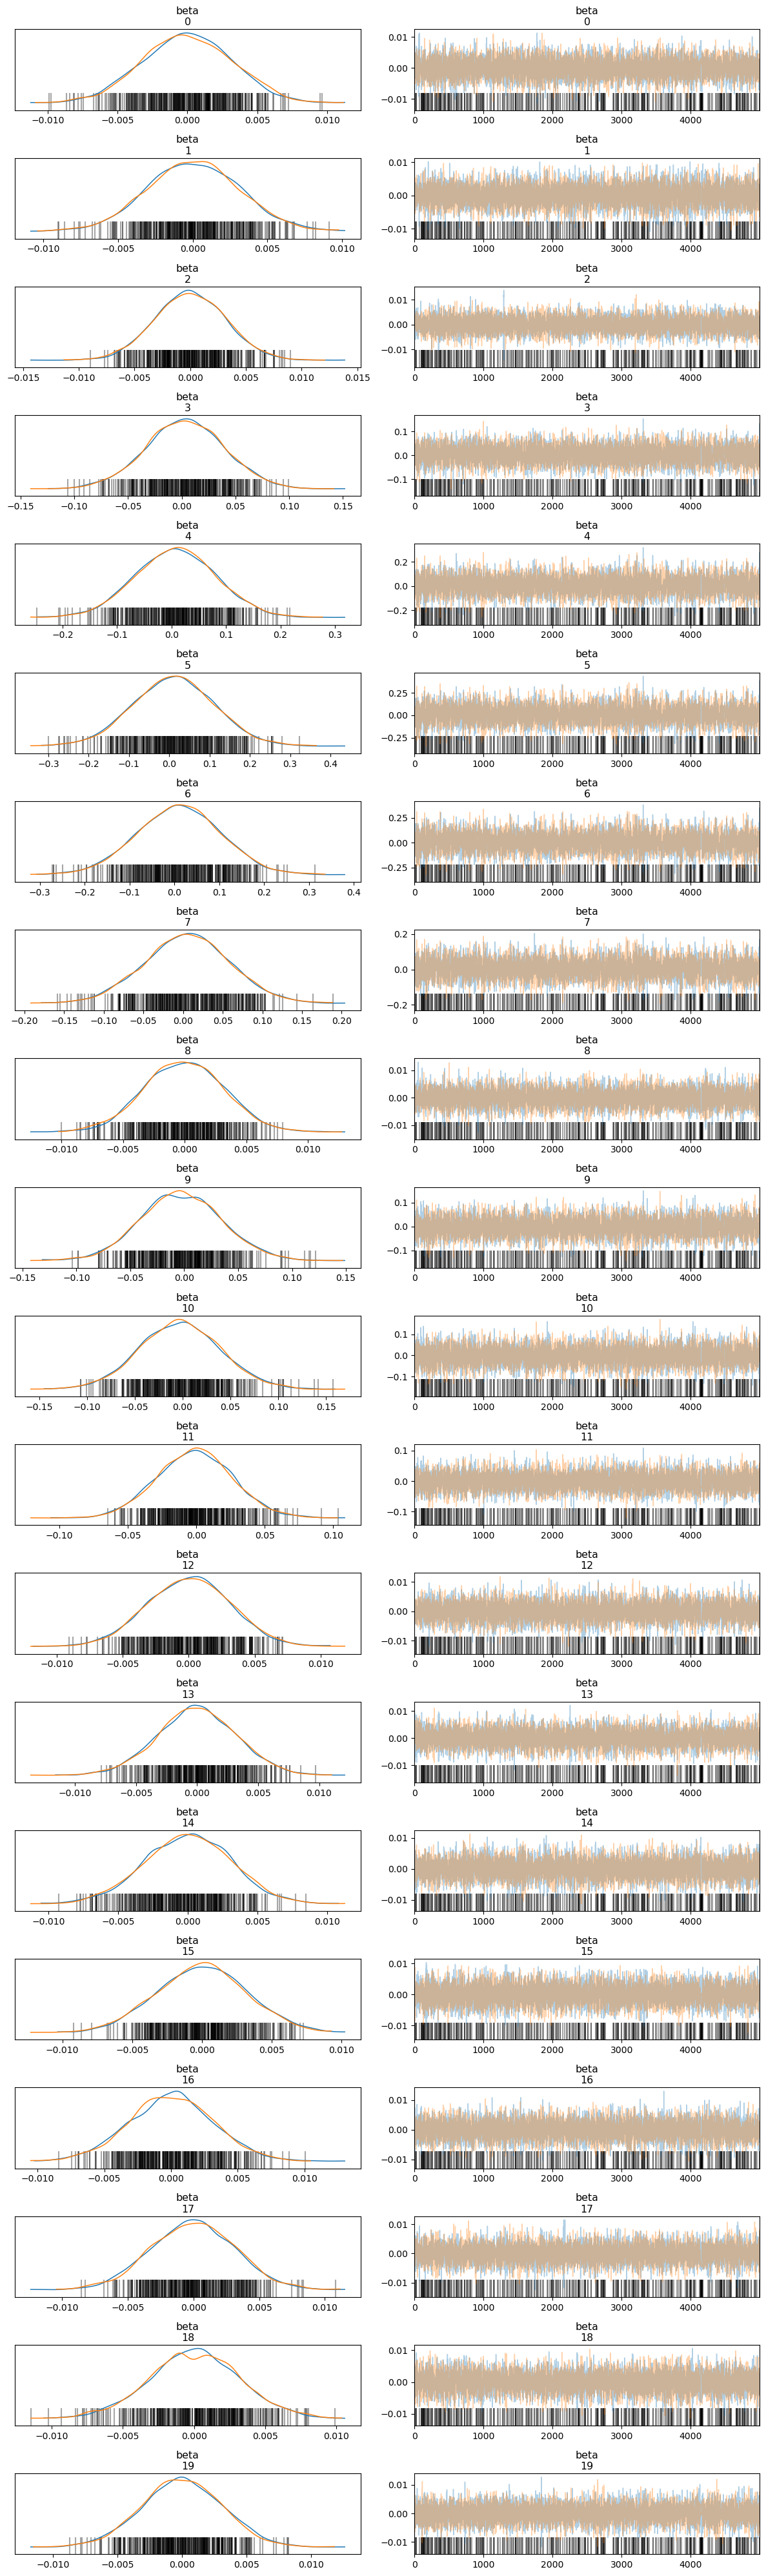

In [19]:
az.plot_trace(mix_data, var_names=["beta"], compact=False)
plt.tight_layout()
plt.show()

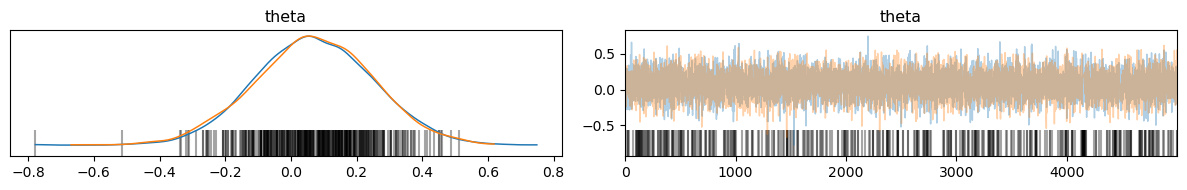

In [17]:
az.plot_trace(mix_data, var_names=["theta"], compact=False)
plt.tight_layout()
plt.show()

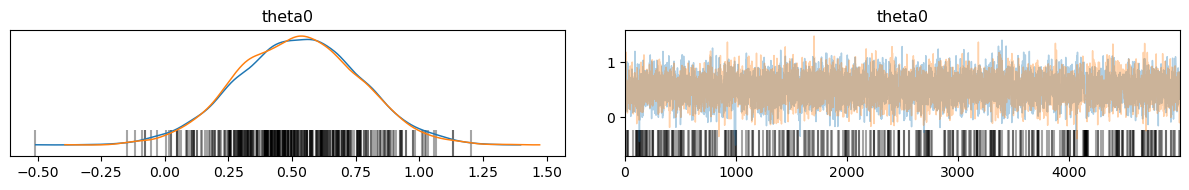

In [18]:
az.plot_trace(mix_data, var_names=["theta0"], compact=False)
plt.tight_layout()
plt.show()

Looking at the plot of $\theta$ and $\theta_0$ they seem to be distributed as normals, however incorrect prior distributions of their parameters may influence both the divergent transitions and the iterations at max treedepth. Hence let's try to model their prior better. Consider now: 
 $$( \mu_s ,\sigma_s) =(0, 0.25)$$ 
$$ (\mu_0,\sigma_0)=(0.5,0.25) $$


In [20]:

mix1 = """
data {
    int<lower=0> N; 
    int<lower=0> g; 
    array[N] real<lower=0> Y;
    matrix[N, g] X;
    matrix[g, g] K0;
    int<lower=0> sigma;
    vector[g] mu;
    vector[N] z;        
}

parameters {
    vector[g] beta; 
    real theta;
    real theta0;
}

model{
    beta~multi_normal(mu,K0);
    theta~normal(0,0.25);
    theta0~normal(0.5,0.25);
    for (n in 1:N) {
        real integral = dot_product(beta, X[n]); // Compute dot product of beta and X[n]
        Y[n] ~ normal(integral+theta*z[n]+theta0, sigma); // Likelihood
    }
}

"""

# Write stan model to file
stan_file = "./stan/sex/mix1.stan"
with open(stan_file, "w") as f:
    print(mix1, file=f)

# Compile stan model
mix1= CmdStanModel(stan_file=stan_file)

10:19:07 - cmdstanpy - INFO - compiling stan file C:\Users\Silvia\Desktop\23-24\BAYES\progetto\stan\sex\mix1.stan to exe file C:\Users\Silvia\Desktop\23-24\BAYES\progetto\stan\sex\mix1.exe
10:19:56 - cmdstanpy - INFO - compiled model executable: C:\Users\Silvia\Desktop\23-24\BAYES\progetto\stan\sex\mix1.exe


In [21]:
# Sample
mix_fit1 = mix1.sample(data=data, chains=2, parallel_chains=2,adapt_delta=0.95,
                             iter_warmup=1000, iter_sampling=5000)

# Convert to arviz data type
mix_data1 = az.from_cmdstanpy(mix_fit1)

10:20:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

13:20:23 - cmdstanpy - INFO - CmdStan done processing.


13:20:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 479 iterations at max treedepth (9.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [22]:
mix_data1.to_netcdf('./stan/sex/output_file1.nc')

'./stan/sex/output_file1.nc'

C:\Users\Silvia\Documents\Anaconda\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (288), generating only 20 plots
  warnings.warn(


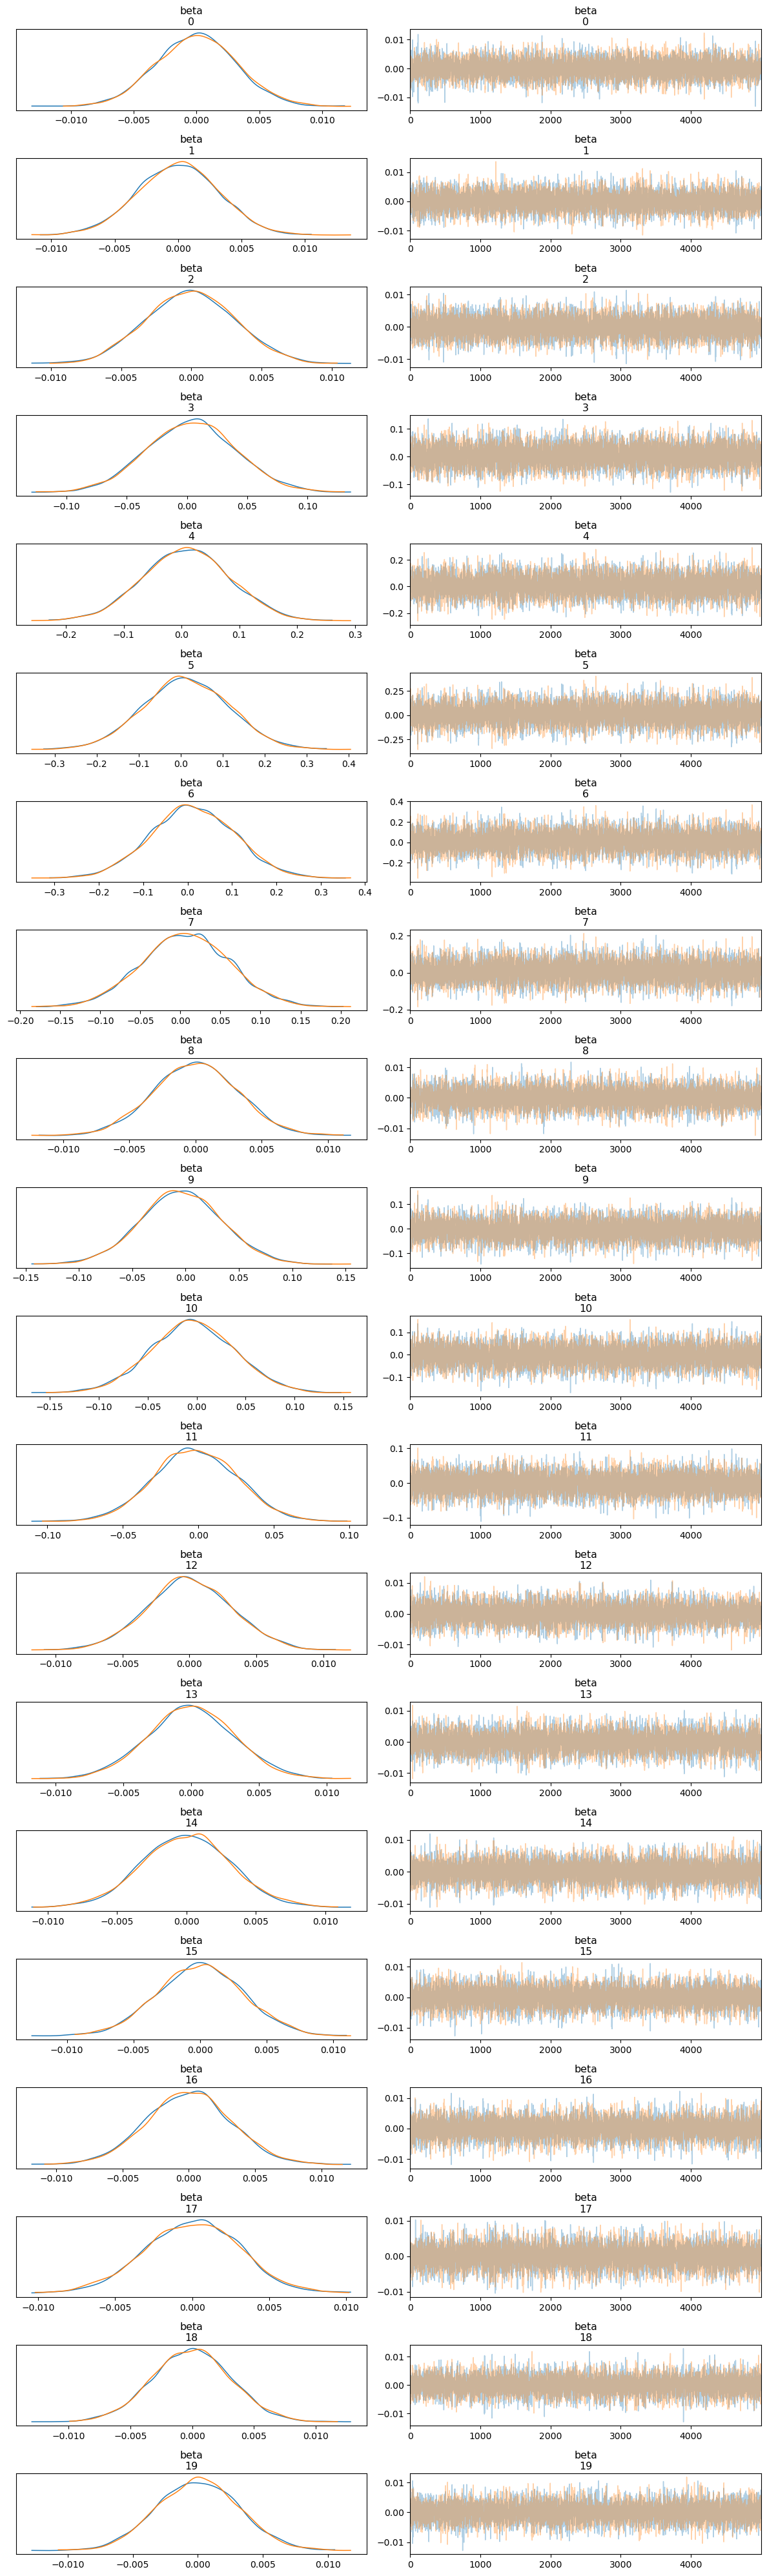

In [26]:
az.plot_trace(mix_data1, var_names=["beta"], compact=False)
plt.tight_layout()
plt.show()

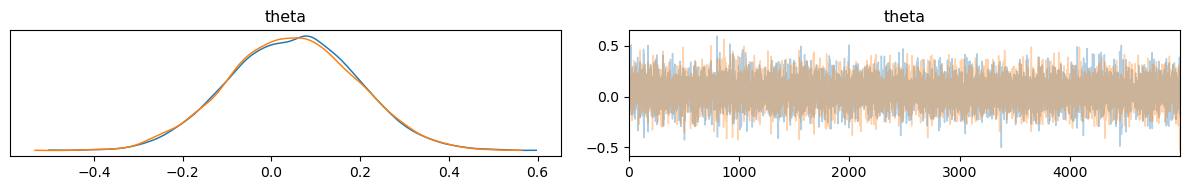

In [27]:
az.plot_trace(mix_data1, var_names=["theta"], compact=False)
plt.tight_layout()
plt.show()

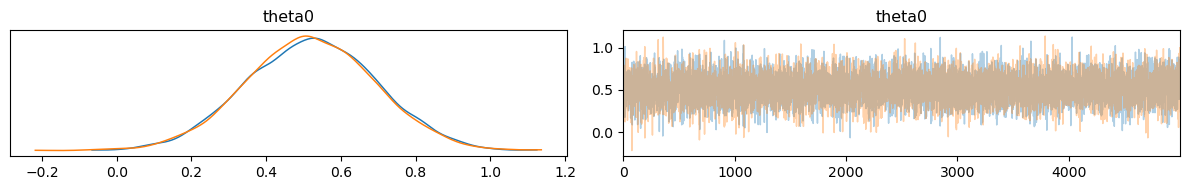

In [28]:
az.plot_trace(mix_data1, var_names=["theta0"], compact=False)
plt.tight_layout()
plt.show()

In [14]:
#for example
#mix_data1 = az.from_netcdf('./stan/sex/output_file1.nc')
beta=np.array(mix_data1.posterior.beta)[1] #from chain 1


In [15]:
#95% CI
import scipy.stats as stats
beta0_hat,_= stats.mode(beta[2000:], axis=0)
beta0_bar= np.mean(beta[2000:], axis=0)
intervals=np.percentile(beta[2000:],[5,95],axis=0)
median_intervals = 2 * beta0_hat - intervals



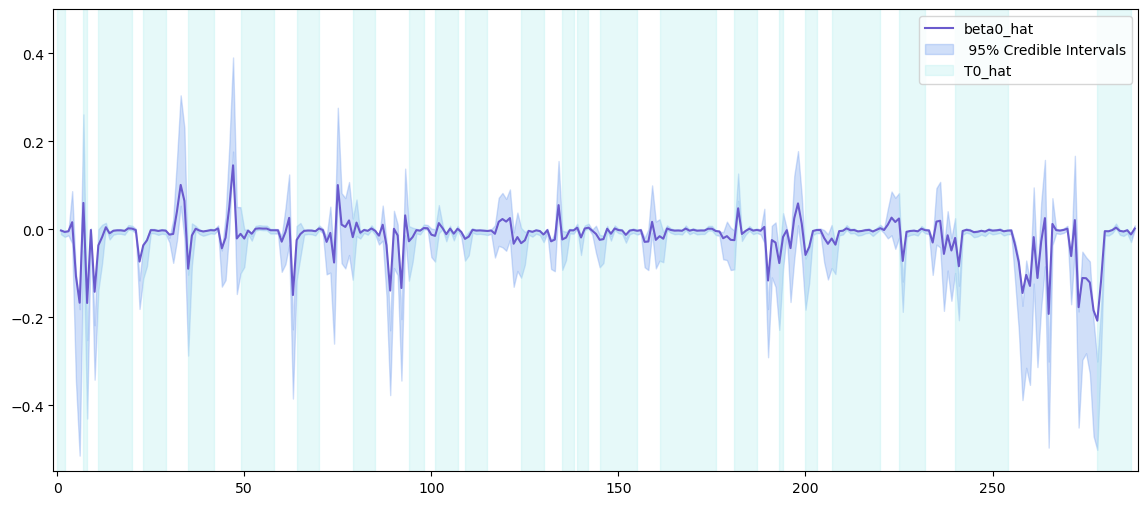

In [16]:
T0_hat = [i + 1 for i, val in enumerate(T0) if val == 1]
plt.figure(figsize=(14, 6))
plt.plot(T,beta0_hat, label='beta0_hat', color='slateblue')
plt.fill_between(T, median_intervals[0, :],median_intervals[1, :], alpha=0.3, label=' 95% Credible Intervals', color='cornflowerblue')
change_indices = np.where(np.diff(T0) != 0)[0]
if T0.iloc[0] == 1:
    change_indices = np.insert(change_indices, 0, 0)
if T0.iloc[-1] == 1:
    change_indices = np.append(change_indices, len(T0) - 1)

x_intervals = change_indices.reshape(-1, 2)
y_intervals = np.array([[-0.55,0.5]] * len(x_intervals))

# Plot the intervals
for x_interval, y_interval in zip(x_intervals[0:len(x_intervals)-2], y_intervals[0:len(y_intervals)-2]):
    plt.fill_betweenx(y=y_interval, x1=x_interval[0], x2=x_interval[1], alpha=0.3, color='paleturquoise')
plt.fill_betweenx(y=y_intervals[-1], x1=x_intervals[-1][0], x2=x_intervals[-1][1], alpha=0.3, color='paleturquoise', label='T0_hat')
plt.xlim(-1, 289)
plt.ylim(-0.55,0.5)
plt.legend()
plt.show()

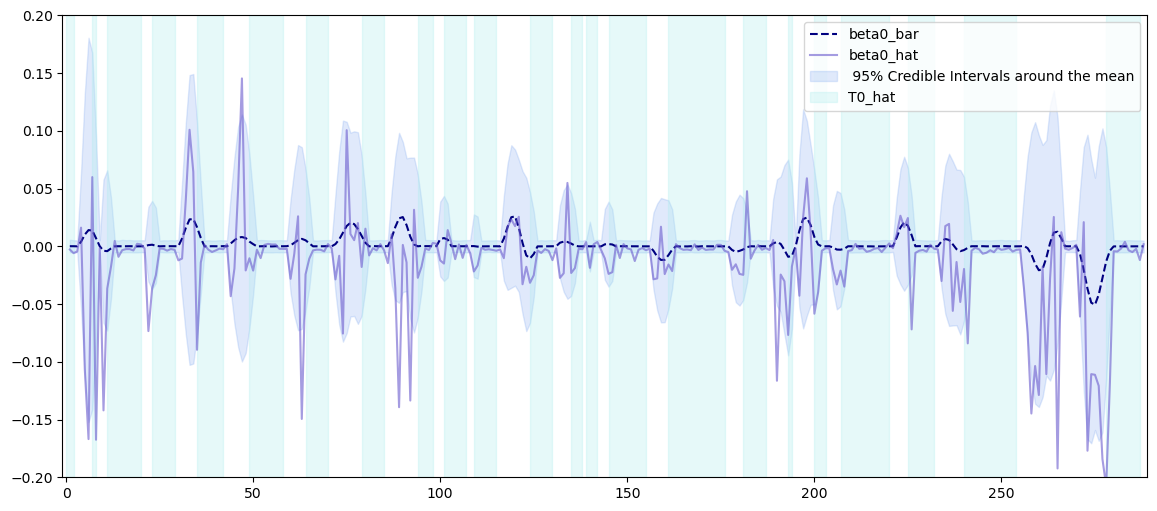

In [17]:
y_intervals = np.array([[-0.2,0.2]] * len(x_intervals))
plt.figure(figsize=(14, 6))
plt.plot(T,beta0_bar,linestyle='dashed',color='navy', label='beta0_bar')
plt.plot(T,beta0_hat, label='beta0_hat', color='slateblue',alpha=0.6)
plt.fill_between(T, intervals[0, :],intervals[1, :], alpha=0.2, label=' 95% Credible Intervals around the mean', color='cornflowerblue')
for x_interval, y_interval in zip(x_intervals[0:len(x_intervals)-2], y_intervals[0:len(y_intervals)-2]):
    plt.fill_betweenx(y=y_interval, x1=x_interval[0], x2=x_interval[1], alpha=0.3, color='paleturquoise')
plt.fill_betweenx(y=y_intervals[-1], x1=x_intervals[-1][0], x2=x_intervals[-1][1], alpha=0.3, color='paleturquoise', label='T0_hat')
plt.xlim(-1, 289)
plt.ylim(-0.2,0.2)
plt.legend()
plt.show()